# Submitted models

As all our best models gave quite variable results given the training set, we submitted the following ones:

## Neuronal Network

In [103]:
library(keras)
use_condaenv("r-tensorflow")
use_session_with_seed(2)

data.train <- read.csv(file.path("..", "data", "training_data.csv"))
data.test <- read.csv(file.path("..", "data", "test_data.csv"))

data.train <- na.omit(data.train)
data.train_PL <- data.train$VALENCE.PLEASANTNESS
data.train$VALENCE.PLEASANTNESS <- NULL
data.train$SWEETORSOUR <- NULL
data.train$Intensity <- as.numeric(data.train$Intensity)

data.test <- na.omit(data.test)
data.test$Intensity <- as.numeric(data.test$Intensity)

Set session seed to 1 (disabled GPU, CPU parallelism)



In [104]:
#names(data.test) <- names(data.train)
cols = names(data.train[, sapply(data.train, function(v) var(v) != 0)])
data.train <- data.train[,cols]
dim(data.train)
data.test <- data.test[,cols]
dim(data.test)

[1]  708 3028

[1]   68 3028

In [105]:
#scaling
all_data <- as.matrix(rbind(data.train, data.test))

for (i in 1:ncol(all_data)){
    max <- max(all_data[,i])
    min <- min(all_data[,i])
    if (max != 1 & min != 0){
        for (j in 1:nrow(all_data)) all_data[j,i] <- (all_data[j,i]-min) / (max-min)
    }
}

#we scale together, and then resplit the data
data.train.sc <- all_data[1:708,]
data.test.sc <- all_data[709:nrow(all_data),]

dim(data.train.sc)
dim(data.test.sc)

[1]  708 3028

[1]   68 3028

In [106]:
#create NN with bootstrap data
NN_bs_predict <- function(N1, N2){
    
     nn <- keras_model_sequential() %>%
      layer_dense(units = N1, activation = 'relu', input_shape = c(3028)) %>%
      layer_dense(units = N2, activation = 'relu',) %>%
      layer_dense(units = 1, activation = 'linear')
    
        #train network
        nn %>% compile(
            loss = 'mse',
            optimizer = 'adam'  
        )
        history <- nn %>% fit(
            data.train.sc,
            data.train_PL,
            batch_size = 350, # stochastic gradient descent batch size
            epochs = 650,
            validation_split = 0.25,
            callbacks = callback_early_stopping(monitor = "val_loss", patience = 10)
        )
        predict(nn, data.test.sc) 
}

In [107]:
y.pred.NN <- NN_bs_predict(600, 100) 

In [113]:
NN_submission <- data.frame(Id = c(1:68), VALENCE.PLEASANTNESS = y.pred.NN)

In [114]:
write.csv(NN_submission, file = 'NN_submission.csv', row.names = FALSE)

## Boosting (best $\lambda$)

In [110]:
library(xgboost)
boost.pl <- xgboost(as.matrix(data.train), label=data.train_PL, eta=0.00316227766016838, objective="reg:squarederror", max.depth=3, nrounds=1000, verbose = 0)
y.pred.boosting1 <- predict(boost.pl, as.matrix(data.test))

In [115]:
boosting_submission <- data.frame(Id = c(1:68), VALENCE.PLEASANTNESS = y.pred.boosting1)
write.csv(boosting_submission, file='boosting_submission.csv', row.names = FALSE)

## Boosting (hyper-grid)

In [116]:
set.seed(123)
boost.pl <- xgboost(as.matrix(data.train), label=data.train_PL, eta=0.01, objective="reg:squarederror", max.depth=1, nrounds=2939, verbose = 0)
y.pred.boosting2 <- predict(boost.pl, as.matrix(data.test))

In [117]:
boosting_submission2 <- data.frame(Id = c(1:68), VALENCE.PLEASANTNESS = y.pred.boosting2)
write.csv(boosting_submission2, file='boosting_submission2.csv', row.names = FALSE)

# Compared predictions

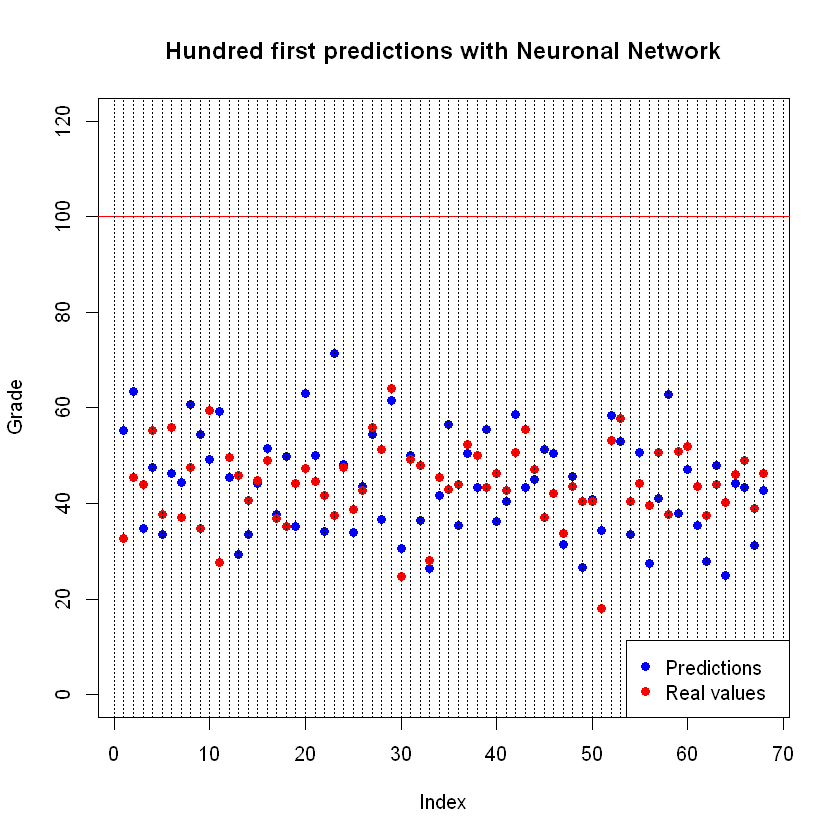

In [118]:
n = 100
plot(y.pred.NN, col = 'blue', ylab = 'Grade', pch = 19, ylim = c(0, 120))
points(y.pred.boosting, col = 'red', pch = 19)
title('Hundred first predictions with Neuronal Network')
abline(h = 100, col = 'red')
for(i in seq(0, n, 1)) abline(v = i, lty = 'dotted')
legend('bottomright', c('Predictions', 'Real values'), col = c('blue', 'red'), pch = 19)